## Highly Active Users

Looking into research on user activity in order to determine how we'd go about labelling a user as "highly active".

The Wikipedia Adventure paper emphasizes the long tail among users in the experiment group. This long tail consists of users above the 90th percentile in the box plot. They measure user activity across 180 days, but in this case that window shouldn't matter.

The "Wikipedians are Born, not Made" paper user "250 edits over the lifespan of the account".

The [Power of the Few vs Wisdom of the Crowd paper](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.212.8218&rep=rep1&type=pdf) segments users into <100, 100–1k, 1–5k, 5–10k, >10k. Note that this paper only looks at data up to some time in 2006.

Felipe Ortega also did early quant work on Wikipedia, and in one paper reused the same segmentation as Kittur et al.

A 2015 report on "Wikimedia Highlights" has a [section for very active editors](https://meta.wikimedia.org/wiki/Wikimedia_Highlights,_September_2015#Wikipedia%E2%80%99s_very_active_editor_numbers_have_stabilized%E2%80%94delve_into_the_data_with_us), using >= 100 edits in a month as the definition.

[Analytics/Metrics definitions#Very active editor](https://www.mediawiki.org/wiki/Analytics/Metric_definitions#Very_active_editor) refers again to the >=100 edits in a month.

Based on this, I think we should go with the old definition and look for number of users who made >= 100 edits within the first month of registration.

## Updated analysis

The analysis below originally examined the 90th percentile and whether users made more than 100 edits in 15 or 30 days. Based on the analysis, neither of these were very meaningful thresholds, so the 95th percentile and 25, 50, and 75 edit thresholds were added.

It also examined 15 and 30 day timeframes. Investigating the results showed that the percentiles were largely similar for 15 and 30 days (the latter typically 1 edit greater), and the difference in number of users who reach the 100 edit threshold is not meaningfully different. It would be tempting to focus on the 15 day period given how close they are, but prior work has defined "very active editors" using a 30 day (or month) timeframe, so I chose to stick with the 30 day timeframe for now, although that puts limitations on the number of users we can grab data for (we can only use users who registered at least 30 days ago).

## 90th Percentile of Newcomer Edits

For our four target wikis, what's the 90th percentile on edits within the first 15 and 30 days after registration? Does it change over time? Let's calculate it on a monthly basis for 2019.

In [1]:
import json
import datetime as dt

import numpy as np
import pandas as pd

from wmfdata import hive, spark, mariadb
from growth import utils

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(data.table)
library(ggplot2)
library(pwr)
library(zoo)

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [6]:
percentile_query = '''
WITH newcomer_edits AS (
    SELECT wiki_db, event_user_id, event_user_registration_timestamp, SUM(1) AS num_edits_30,
    SUM(IF(unix_timestamp(event_timestamp) -
           unix_timestamp(event_user_creation_timestamp) < 15 * 86400, 1, 0)) AS num_edits_15
    FROM wmf.mediawiki_history
    WHERE snapshot = "2020-03"
    AND wiki_db IN ("cswiki", "kowiki", "viwiki", "arwiki")
    AND event_entity = "revision"
    AND event_type = "create"
    AND event_user_is_created_by_self = true -- only self-registrations
    AND size(event_user_is_bot_by) = 0 -- no bots
    AND size(event_user_is_bot_by_historical) = 0 -- positively no bots
    AND unix_timestamp(event_timestamp) -
        unix_timestamp(event_user_creation_timestamp) < 30 * 86400 -- less than 30 days
    AND event_user_registration_timestamp >= "2019-01-01"
    AND event_user_registration_timestamp < "2020-01-01"
    GROUP BY wiki_db, event_user_id, event_user_registration_timestamp
)
SELECT wiki_db, trunc(event_user_registration_timestamp, "MONTH") as month,
       COUNT(event_user_id) AS num_registrations,
       SUM(IF(num_edits_15 >= 100, 1, 0)) AS num_very_active_15,
       SUM(IF(num_edits_30 >= 100, 1, 0)) AS num_very_active_30,
       SUM(IF(num_edits_30 >= 25, 1, 0)) AS num_over_25_30,
       SUM(IF(num_edits_30 >= 50, 1, 0)) AS num_over_50_30,
       SUM(IF(num_edits_30 >= 75, 1, 0)) AS num_over_75_30,
       percentile(num_edits_15, 0.9) AS perc_90_edits_15,
       percentile(num_edits_30, 0.9) AS perc_90_edits_30,
       percentile(num_edits_30, 0.95) AS perc_95_edits_30
FROM newcomer_edits
GROUP BY wiki_db, trunc(event_user_registration_timestamp, "MONTH")
'''

In [7]:
percentiles = spark.run(percentile_query)

In [8]:
percentiles['prop_very_active_15'] = percentiles['num_very_active_15'] / percentiles['num_registrations']
percentiles['prop_very_active_30'] = percentiles['num_very_active_30'] / percentiles['num_registrations']
percentiles['prop_over_25_30'] = percentiles['num_over_25_30'] / percentiles['num_registrations']
percentiles['prop_over_50_30'] = percentiles['num_over_50_30'] / percentiles['num_registrations']
percentiles['prop_over_75_30'] = percentiles['num_over_75_30'] / percentiles['num_registrations']

In [ ]:
percentiles.sort_values(['wiki_db', 'month'])

## Proportion of Very Active New Editors

Let's plot those proportions of highly active editors over time. For simplicity, we'll just use the 30-day period.

In [11]:
percentiles['log_month'] = percentiles['month'].astype(str)

In [20]:
r_data = percentiles[['wiki_db', 'log_month', 'prop_very_active_30']]

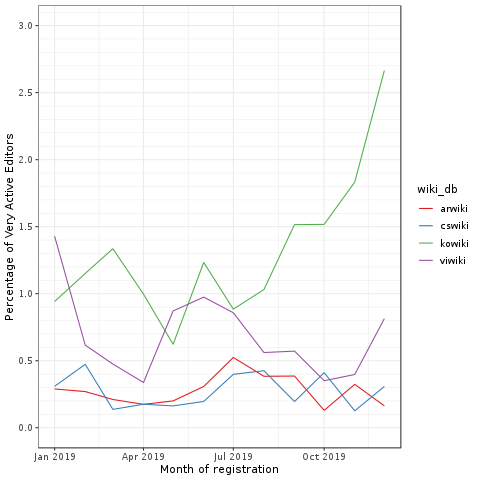

In [21]:
%%R -i r_data

r_data$log_month = as.Date(r_data$log_month)

ggplot(r_data, aes( x = log_month, y = 100 * prop_very_active_30, color = wiki_db)) +
    theme_bw() +
    scale_y_continuous("Percentage of Very Active Editors", limits = c(0, 3),
                       breaks = c(0:10) * 0.5, minor_breaks = c(0:35) / 10) +
    scale_x_date("Month of registration") +
    scale_color_brewer(palette = "Set1") +
    geom_line()

## 90th Percentile of Newcomer Edits

Similarly, let's plot the number of edits needed to quality for the 90th percentile. Keep in mind that since we're counting revisions, this is the 90th percentile of *newcomers who made 1 or more edits*. New registrations who didn't edit aren't part of this dataset.

In [34]:
r_data = percentiles[['wiki_db', 'log_month', 'perc_90_edits_30']]

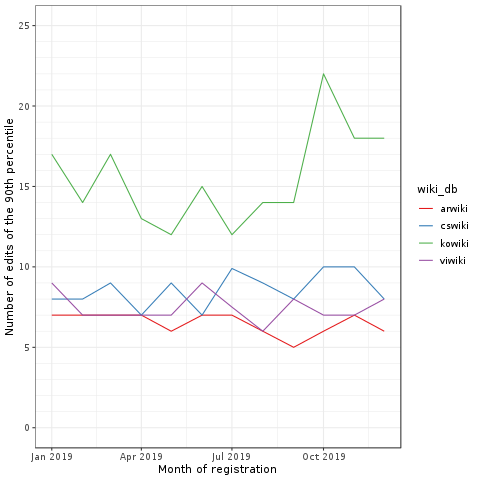

In [37]:
%%R -i r_data

r_data$log_month = as.Date(r_data$log_month)

ggplot(r_data, aes( x = log_month, y = perc_90_edits_30, color = wiki_db)) +
    theme_bw() +
    scale_y_continuous("Number of edits of the 90th percentile", limits = c(0, 25),
                       minor_breaks = c(0:25)) +
    scale_x_date("Month of registration") +
    scale_color_brewer(palette = "Set1") +
    geom_line()

## Conclusions so far

We find that for all wikis, the number of edits over the first 30 days that are needed to be in the 90th percentile are relatively moderate, generally in the 5–10 edit range. Korean Wikipedia is distinctively higher throughout 2019, always more than 10 edits, and often 15 or higher.

When it comes to the percentage of new users who reach 100 edits within the first 30 days (and note that bots are not part of this measure), we see some differences between wikis. Again, Korean is often higher than the others, and particularly towards the end of the year. Czech and Arabic are consistently at the low end, with the percentage consistently landing in the 0.1–0.5% range. Vietnamese had more fluctuation, but appears to consistently be in the 0.5–1.0% range, generally towards the lower end of that range.

Based on this, the 90th percentile seems too low to be used as a way to label users as "highly active". It's also not clear that 100 edits in the first 30 days is a meaningful threshold to use, since so few users actually make it. Did we make a meaningful change if we went from 0.5% to 0.8%, although we can determine that with statistical significance?

## Other thresholds

We do the same kind of plots, but for the 25, 50, and 75 edit thresholds.

In [13]:
r_data = percentiles[['wiki_db', 'log_month', 'prop_over_25_30']]

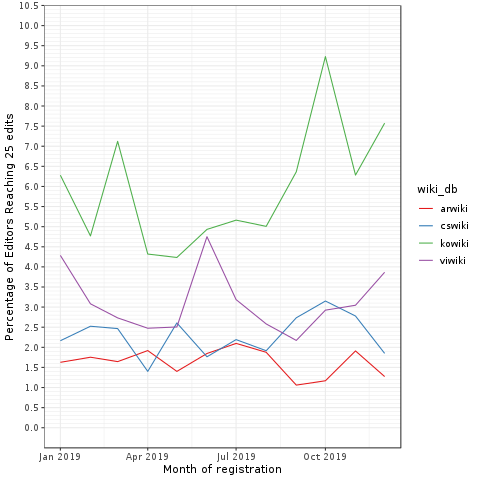

In [16]:
%%R -i r_data

r_data$log_month = as.Date(r_data$log_month)

ggplot(r_data, aes( x = log_month, y = 100 * prop_over_25_30, color = wiki_db)) +
    theme_bw() +
    scale_y_continuous("Percentage of Editors Reaching 25 edits", limits = c(0, 10),
                       breaks = c(0:25) * 0.5, minor_breaks = c(0:110) / 10) +
    scale_x_date("Month of registration") +
    scale_color_brewer(palette = "Set1") +
    geom_line()

So for 25 edits, we're looking at typically between 5% and 10% of new users on Korean, but <5% on all the other wikis.

Let's look at 50, then.

In [17]:
r_data = percentiles[['wiki_db', 'log_month', 'prop_over_50_30']]

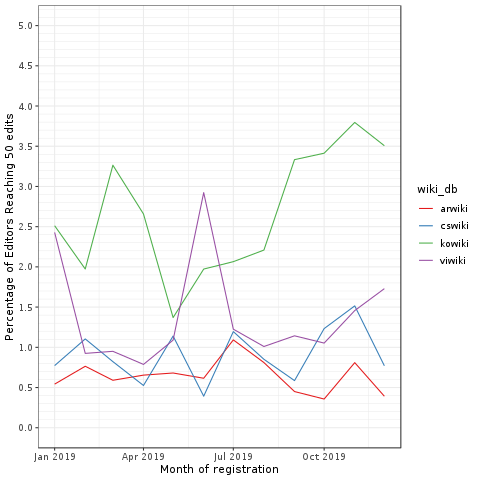

In [19]:
%%R -i r_data

r_data$log_month = as.Date(r_data$log_month)

ggplot(r_data, aes( x = log_month, y = 100 * prop_over_50_30, color = wiki_db)) +
    theme_bw() +
    scale_y_continuous("Percentage of Editors Reaching 50 edits", limits = c(0, 5),
                       breaks = c(0:25) * 0.5, minor_breaks = c(0:110) / 10) +
    scale_x_date("Month of registration") +
    scale_color_brewer(palette = "Set1") +
    geom_line()

## 95th Percentile of Newcomer Edits

We'll also plot the 95th percentile, to see what that looks like.

In [22]:
r_data = percentiles[['wiki_db', 'log_month', 'perc_95_edits_30']]

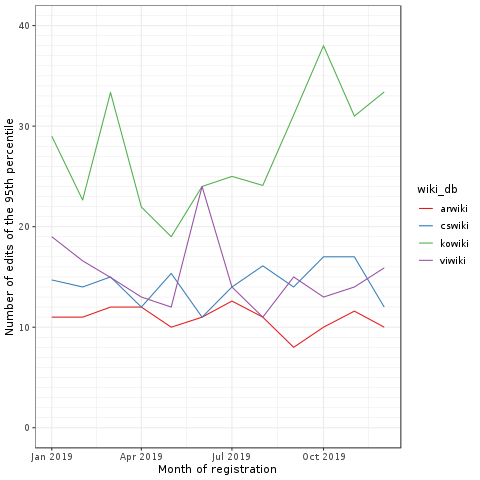

In [24]:
%%R -i r_data

r_data$log_month = as.Date(r_data$log_month)

ggplot(r_data, aes( x = log_month, y = perc_95_edits_30, color = wiki_db)) +
    theme_bw() +
    scale_y_continuous("Number of edits of the 95th percentile", limits = c(0, 40),
                       minor_breaks = c(0:50)) +
    scale_x_date("Month of registration") +
    scale_color_brewer(palette = "Set1") +
    geom_line()

We can see here that on three of the wikis, a 25 edit threshold labels less than 5% of the users as "Very Active". However, on Korean that's not the case.

## Conclusion so far

Given these analyses, it looks like we might want to use >= 50 edits within 30 days as our threshold for "Very Active newcomers". That lands us at about 1% of newcomers who edit on a lot of the wikis. While the proportion is much higher in Korean, it's still low enough that most of the newcomers *who edit* are left out.